## Use ML to diffrentiate between Ketamine and Midazolam group on 7-day past infusion resting state data (10m)

In [62]:
work_dir = '/media/Data/work/kpeCONN'

# %%load parcellation (Yeo? / Shen?)
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nilearn
from nilearn import input_data
from nilearn import plotting
import scipy
import seaborn as sns
from sklearn.covariance import GraphicalLassoCV

In [11]:
# shen
atlas_filename = '/home/or/Downloads/shenPar/shen_1mm_268_parcellation.nii.gz'
atlas_labes = pd.read_csv('/home/or/Downloads/shenPar/shen_268_parcellation_networklabels.csv')
colors = pd.read_csv('/home/or/Downloads/shenPar/shen_268_parcellation_networklabels_colors.csv')
coords = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)

atlas_labes = np.array(atlas_labes)
atlas_labes.shape

(268, 2)

In [12]:
# add sphere around each 
coords
masker = nilearn.input_data.NiftiSpheresMasker(
    seeds=coords, smoothing_fwhm=6, radius=5.,
    detrend=True, standardize=True, low_pass=0.1, high_pass=0.01, t_r=1)


In [104]:
# extract RS data and create vector for each subject
def removeVars (confoundFile):
    # this method takes the csv regressors file (from fmriPrep) and chooses a few to confound. You can change those few
    import pandas as pd
    confound = pd.read_csv(confoundFile,sep="\t", na_values="n/a")
    finalConf = confound[['csf','white_matter', 'framewise_displacement', 'dvars', 'std_dvars',
                          'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z',
                        ]] # can add 'global_signal' also ,
     # change NaN of FD to zero
    finalConf = np.array(finalConf.fillna(0.0))
    #finalConf[0,2] = 0 # if removing FD than should remove this one also
    return finalConf
#from nilearn.input_data import NiftiMasker
    # define masker here

from nilearn.input_data import NiftiLabelsMasker
# masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,t_r=1, high_pass=.01, low_pass=0.1,
#                            smoothing_fwhm=6
#                            )

    
#masker = NiftiMasker(mask_img=mask_file, standardize=True, detrend = True, smoothing_fwhm =2,
 #                          verbose=5, high_pass = 0.01, t_r = 1.)
from nilearn.connectome import ConnectivityMeasure

connectome_measure = ConnectivityMeasure(kind='partial correlation', vectorize = False, discard_diagonal=False)

## if using lasso
covariance_estimator = GraphicalLassoCV(cv=4,  n_jobs=10)

In [64]:
# take func and confound files and extract vectors for each
subject_list = ['008','1223','1253','1263','1293','1307','1315','1322','1339','1343','1351','1356','1364','1369'
                ,'1387','1390','1403','1464', '1468', '1480']#, '1499']

func_template = '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_BIDS/derivatives/fmriprep/sub-{sub}/ses-{session}/func/sub-{sub}_ses-{session}_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
confound_template = '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_BIDS/derivatives/fmriprep/sub-{sub}/ses-{session}/func/sub-{sub}_ses-{session}_task-rest_desc-confounds_regressors.tsv'

In [16]:
### Run this only to extract timeseries from the start if it was extracted already - run next cell only
session = '2'
for sub in subject_list:
    print(f'Analyzing subject {sub}')
    confound = confound_template.format(sub=sub, session = session)    
    filename = func_template.format(sub=sub, session = session)
   
    try:
        timeseries_each_subject = masker.fit_transform(filename, confounds=removeVars(confound))
        np.save(work_dir + '/sub-'+ sub + '_session2CorrSphere',timeseries_each_subject)
    except:
        print (f'Subject {sub} have no data file')
    

Analyzing subject 008
Analyzing subject 1223
Analyzing subject 1253
Analyzing subject 1263
Analyzing subject 1293
Analyzing subject 1307
Analyzing subject 1315
Analyzing subject 1322
Analyzing subject 1339
Analyzing subject 1343
Analyzing subject 1351
Analyzing subject 1356
Analyzing subject 1364
Analyzing subject 1369
Analyzing subject 1387
Analyzing subject 1390
Analyzing subject 1403
Analyzing subject 1464
Analyzing subject 1468
Analyzing subject 1480
Analyzing subject 1499


In [65]:
## load files and run lasso
correlations = []
for sub in subject_list:
    print(f'Running subject {sub}')
    ts = np.load(work_dir + '/sub-'+ sub + '_session2CorrSphere.npy')
    covariance_estimator.fit(ts)
    # transfer to fishers' z
    mat = np.arctan(covariance_estimator.covariance_)
    correlations.append(mat)
correlations = np.squeeze(correlations)
correlations.shape

Running subject 008
Running subject 1223
Running subject 1253
Running subject 1263
Running subject 1293
Running subject 1307
Running subject 1315
Running subject 1322
Running subject 1339
Running subject 1343
Running subject 1351


/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/sklearn/covariance/_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 5.862e-04
  % (max_iter, d_gap), ConvergenceWarning)


Running subject 1356
Running subject 1364
Running subject 1369
Running subject 1387
Running subject 1390
Running subject 1403
Running subject 1464


/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/sklearn/covariance/_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 2.972e-04
  % (max_iter, d_gap), ConvergenceWarning)


Running subject 1468
Running subject 1480


(20, 268, 268)

## Plot mean correlation matrix

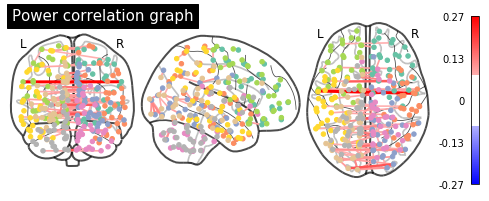

In [110]:
# Tweak edge_threshold to keep only the strongest connections.
mean_corrMat = np.mean(correlations, axis=0)
plotting.plot_connectome(mean_corrMat, coords, title='Power correlation graph',
                         edge_threshold='99.8%', node_size=20, colorbar=True)

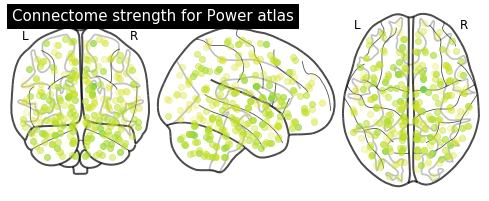

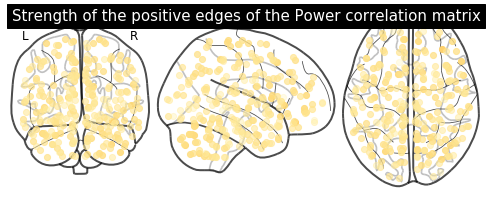

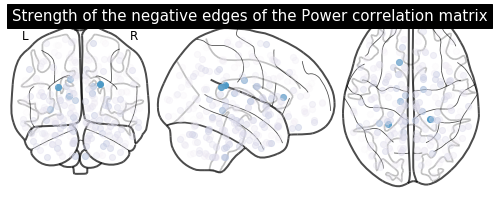

In [111]:
## plot strength
plotting.plot_connectome_strength(
    mean_corrMat, coords, title='Connectome strength for Power atlas'
)

## just positive
from matplotlib.pyplot import cm

# plot the positive part of of the matrix
plotting.plot_connectome_strength(
    np.clip(mean_corrMat, 0, mean_corrMat.max()), coords, cmap=cm.YlOrRd,
    title='Strength of the positive edges of the Power correlation matrix'
)

# plot the negative part of of the matrix
plotting.plot_connectome_strength(
    np.clip(mean_corrMat, mean_corrMat.min(), 0), coords, cmap=cm.PuBu,
    title='Strength of the negative edges of the Power correlation matrix'
)


In [112]:
## make everything ready for ML
# turn to vector
vec_corr = []
for i in correlations:
    corVec = nilearn.connectome.sym_matrix_to_vec(i)
    vec_corr.append(corVec)
np.array(vec_corr).shape

(20, 36046)

## Setting variables

In [113]:
X = np.array(vec_corr)
#X = X.reshape(X.shape[0], midArr_reshape.shape[1])
X.shape

(20, 36046)

In [114]:
#label each group
# 1 = ketamine, 0 = midazolam
group_label = ['1', '1', '2', '2', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '1', '2', '2', '1', '2', '2']#, '1']
Y = group_label

In [115]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

model = XGBClassifier(n_jobs=8, 
                     verbose = 9, random_state=None)

## Here we use stratified K-fold with shuffling to generate different shuffling of leave one subject out
cv = StratifiedKFold(n_splits=5, shuffle=True) # running for each subject
mean_scores = []

#svc = svm.SVC(kernel="rbf") #LinearSVC(random_state=None, verbose=5, C=1)
cv_scores = cross_val_score(model,
                            X,
                            y=group_label,
                            cv=cv,
                            groups=group_label,
                            scoring= "roc_auc",
                            n_jobs=10, # set number of CPUs
                            verbose = 5 # set some details of the activity 
                            )
mean_scores.append(cv_scores.mean())

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    3.5s remaining:    5.3s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    3.8s finished


In [116]:
cv_scores

array([0.25, 0.25, 0.25, 0.  , 0.75])

In [61]:
n_iter = 100
rand_score = []
for i in range(n_iter):
    print(f' Running {i+1} iteration')
    mean_scores = []
    scores = cross_val_score(model,
                            X,
                            y=group_label,
                            cv=cv,
                            groups=group_label,
                            scoring= "roc_auc",
                            n_jobs=10, # set number of CPUs
                            #verbose = 5 # set some details of the activity 
                            )
    mean_scores.append(scores.mean())
    rand_score.append(mean_scores)

 Running 1 iteration
 Running 2 iteration
 Running 3 iteration
 Running 4 iteration
 Running 5 iteration
 Running 6 iteration
 Running 7 iteration
 Running 8 iteration
 Running 9 iteration
 Running 10 iteration
 Running 11 iteration
 Running 12 iteration
 Running 13 iteration
 Running 14 iteration
 Running 15 iteration
 Running 16 iteration
 Running 17 iteration
 Running 18 iteration
 Running 19 iteration
 Running 20 iteration
 Running 21 iteration
 Running 22 iteration
 Running 23 iteration
 Running 24 iteration
 Running 25 iteration
 Running 26 iteration
 Running 27 iteration
 Running 28 iteration
 Running 29 iteration
 Running 30 iteration
 Running 31 iteration
 Running 32 iteration
 Running 33 iteration
 Running 34 iteration
 Running 35 iteration
 Running 36 iteration
 Running 37 iteration
 Running 38 iteration
 Running 39 iteration
 Running 40 iteration
 Running 41 iteration
 Running 42 iteration
 Running 43 iteration
 Running 44 iteration
 Running 45 iteration
 Running 46 iterati

Accuracy: 0.6750000000000002 (CI5%-95% [0.5 0.8])


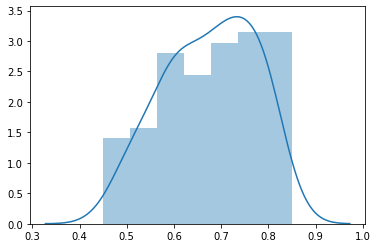

In [53]:
rand_score = np.array(rand_score)
print(f'Accuracy: {np.mean(rand_score)} (CI5%-95% {np.quantile(rand_score, [0.05,0.95])})')
sns.distplot(rand_score)

In [ ]:
## Lets do permutation tests - shuffling the condition label
import random
condPerm = np.array(group_label)
permScor = []
#cv = KFold(n_splits=10)
for i in range(n_iter):
    print (f'Running the {i+1} iteration')
    random.shuffle(condPerm)
    print(condPerm)
    
    mean_scores = []
    cv_scores = cross_val_score(model,
                            X,
                            y=condPerm,
                            cv=cv,
                            groups=condPerm,
                            scoring="roc_auc",
                            n_jobs=11, # set number of CPUs
                            #verbose = 5 # set some details of the activity 
                            )
    mean_scores.append(cv_scores.mean())
    permScor.append(mean_scores)

In [ ]:
permScor = np.array(permScor)
print(f'AUC: {np.mean(permScor)} (CI5%-95% {np.quantile(permScor, [0.05,0.95])})')
sns.distplot(permScor)

## To test ourselfs - lets compare the first session
We expect no differences at all in this one

In [ ]:
session = '1'
correlations_1 = []
for sub in subject_list:
    print(f'Analyzing subject {sub}')
    confound = confound_template.format(sub=sub, session = session)    
    filename = func_template.format(sub=sub, session = session)
   
    try:
        timeseries_each_subject = masker.fit_transform(filename, confounds=removeVars(confound))
    except:
        print (f'Subject {sub} have no data file')
    
    #correlation = connectome_measure.fit_transform([timeseries_each_subject])
    #correlation = np.arctan(correlation) # z transform it
    #correlations.append(correlation)
    covariance_estimator.fit(timeseries_each_subject)
    correlations_1.append(covariance_estimator.covariance_)

# Get array in good numpy structure
correlations_1 = np.squeeze(correlations_1)

In [ ]:
## make everything ready for ML
# turn to vector
vec_corr1 = []
for i in correlations_1:
    corVec = nilearn.connectome.sym_matrix_to_vec(i)
    vec_corr1.append(corVec)
np.array(vec_corr1).shape

In [ ]:
X_1 = np.array(vec_corr1)
#X = X.reshape(X.shape[0], midArr_reshape.shape[1])
X_1.shape

In [ ]:
model2 = XGBClassifier(n_jobs=8, 
                     verbose = 9, random_state=None)

## Here we use stratified K-fold with shuffling to generate different shuffling of leave one subject out
cv = StratifiedKFold(n_splits=6, shuffle=True) # running for each subject
mean_scores2 = []

#svc = svm.SVC(kernel="rbf") #LinearSVC(random_state=None, verbose=5, C=1)
cv_scores = cross_val_score(model2,
                            X_1,
                            y=group_label,
                            cv=cv,
                            groups=group_label,
                            scoring= "roc_auc",
                            n_jobs=10, # set number of CPUs
                            verbose = 5 # set some details of the activity 
                            )
mean_scores2.append(cv_scores.mean())

In [ ]:
cv_scores

In [ ]:
n_iter = 100
rand_score1 = []
for i in range(n_iter):
    print(f' Running {i+1} iteration')
    mean_scores = []
    scores = cross_val_score(model2,
                            X_1,
                            y=group_label,
                            cv=cv,
                            groups=group_label,
                            scoring= "roc_auc",
                            n_jobs=10, # set number of CPUs
                            #verbose = 5 # set some details of the activity 
                            )
    mean_scores.append(scores.mean())
    rand_score1.append(mean_scores)

In [ ]:
rand_score1 = np.array(rand_score1)
print(f'AUC: {np.mean(rand_score1)} (CI5%-95% {np.quantile(rand_score1, [0.05,0.95])})')
sns.distplot(rand_score1)

### First session results are basically noise, as expected

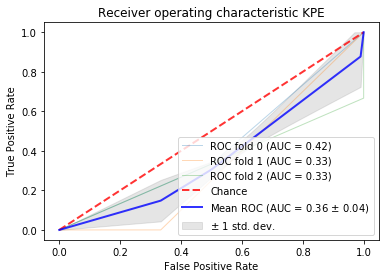

In [118]:
## lets build ROC 
## taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

y=np.array(list(map(int, group_label)) )
cv = StratifiedKFold(n_splits=3, shuffle=True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    
    model.fit(X[train], y[train])
    viz = plot_roc_curve(model, X[test,:], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic KPE")
ax.legend(loc="lower right")
plt.show()

